# Email Detection and Classification  
  
  

## Introduction

This project aims to do an automatic income email detection, cleaning and classification. The application of this project is to reduce the time for customer service agents when companies receive emails from clients.  


The detection part includes to detect the email language and email type (spam or not spam). The cleaning part aims to do the text cleaning, email content cleaning, the email title (receiver, date and time, etc) cleaning or even email translation. The classification part is focused on transfering the text into different array (Tfidf), testing different machine learning methods and hyperparameter tunning. And last, if I have time, I will try to put the project into production, which means that put it to a docker and do everything automatically.

## Dataset

- Personal gmail: As I can't find a proper email dataset, I am going to use my emails from gmail to see if I can do something or not.

## Methods

- Natural language processing
- Semi-supervised learning (which I don't know yet)
- Artificial Neural Network
- SVM, Naive Bayes, or random forest classification 
- Docker or Azure (optional)


## Challenges

- Email content cleaning may be a mess. 
- Creating a pipeline to do the automation.
- The semi-supervised learning is something I only heard but never done it before. As my dataset is an unlebelled data, I may need the semi-supervised learning to help me to label the data.
- I want to try if I can use word-embedding technique in this project.
- Docker/Azure: I have never tried Docker/Azure by myself. No clues if this will work or not.

--------------------------------------------------------

## Let's start!
  
    
-----------------------------------------------------------

## 1. Data Cleaning

### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
#stemmer = SnowballStemmer('spanish')
import langid
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import svm
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import mailbox
from glob import glob
import langid

### 1.2 Read the mbox file

#### As the original file is very huge (2.8Gb), I splited it into several chunks and only read some files with around 800Mb of size.

In [2]:
# Using glob to retrieve all file name with similar starting title and stack them together

paths = sorted(glob('/home/chao/Desktop/Ideas/gmails/mail_*.mbox'))

# Create a blank list to store the parsing results
mail = []

for path in paths:
    for message in mailbox.mbox(path):
        subject = message["subject"]
        label = message["X-Gmail-Labels"]
        #body = re.findall(r'(Content-Transfer-Encoding).*\s*.*\s*.*\s*.*\s*.*\s*.*\s', message.get_payload(decode=True))
        text = (subject, label)
        mail.append(text)

#### Convert the list into DatFrame and change the columns' title

In [3]:
df = pd.DataFrame(mail)
df = df.rename(columns = {0:"Title", 1:"Label"})
df.to_csv("df.csv")
df.head()

,Title,Label
0,=?utf-8?q?Reminder_for_Workshop_=3A_Introducci...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=
1,1 update in ironhack,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=
2,[SUSPECTED SPAM] =?utf-8?B?W0ltcG9ydGFudF0gQ29...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=
3,"Data Science, #ODSC Barcelona list: ""Skewed Da...",=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=
4,Welcome + Datasets Maintained by Kaggle,=?UTF-8?B?5pS25Lu25Yyj?=


In [4]:
df.shape

(3399, 2)

In [5]:
df = pd.read_csv("df.csv", index_col=0)

### 1.3 Data cleaning

In [6]:
# Let's go for the target variable first
df["Label"].value_counts().head()

=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=                    2171
=?UTF-8?B?5pS25Lu25Yyj?=                                         656
=?UTF-8?B?5a+E5Lu25YKZ5Lu9?=                                     190
=?UTF-8?B?5bey5bCB5a2YLOWvhOS7tuWCmeS7vSzph43opoHpg7Xku7Y=?=      90
=?UTF-8?B?5a+E5Lu25YKZ5Lu9LOaUtuS7tuWMoyzph43opoHpg7Xku7Y=?=      64
Name: Label, dtype: int64

#### Ok, it is utf-8 encoded, I need to decode them first

In [7]:
from email.header import decode_header 
#import ast

decode_labels = []
for label in df["Label"]:
    text = decode_header(label)[0][0].decode('utf-8')
    decode_labels.append(text)

In [8]:
df = pd.concat([df, pd.Series(decode_labels)], axis=1)

In [9]:
df = df.rename(columns = {0:"Label_cn"})
df.head()

,Title,Label,Label_cn
0,=?utf-8?q?Reminder_for_Workshop_=3A_Introducci...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件"
1,1 update in ironhack,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件"
2,[SUSPECTED SPAM] =?utf-8?B?W0ltcG9ydGFudF0gQ29...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件"
3,"Data Science, #ODSC Barcelona list: ""Skewed Da...",=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件"
4,Welcome + Datasets Maintained by Kaggle,=?UTF-8?B?5pS25Lu25Yyj?=,收件匣


#### Ehhhh, it is in Chinese, no one is going to understand what I have done, I will translate it into English

In [10]:
def replace_label(text):
    text = re.sub(r'重要郵件','',text)
    text = re.sub(r'收件匣','Incoming',text)
    text = re.sub(r'寄件備份','Sent',text)
    text = re.sub(r'已封存','',text)
    text = re.sub(r'待辦','',text)
    text = re.sub(r'Alexis','Alexis',text)
    text = re.sub(r'已加星號','',text)
    text = re.sub(r'文件','Documents',text)
    text = re.sub(r'ChaoTing@creaf.uab.es','Ecology',text)
    text = re.sub(r'購物','Shopping',text)
    text = re.sub(r'未讀訊息','',text)
    text = re.sub(r'保固 Garantee','Garantee',text)
    text = re.sub(r'b87605421@ntu.edu.tw','',text)
    text = re.sub(r'中國信託','Bank',text)
    text = re.sub(r',', '', text)
    return text

In [11]:
df["Label_text"] = df["Label_cn"].apply(replace_label)

In [12]:
df.head()

,Title,Label,Label_cn,Label_text
0,=?utf-8?q?Reminder_for_Workshop_=3A_Introducci...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming
1,1 update in ironhack,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming
2,[SUSPECTED SPAM] =?utf-8?B?W0ltcG9ydGFudF0gQ29...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming
3,"Data Science, #ODSC Barcelona list: ""Skewed Da...",=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming
4,Welcome + Datasets Maintained by Kaggle,=?UTF-8?B?5pS25Lu25Yyj?=,收件匣,Incoming


In [13]:
df["Label_text"].value_counts()

Incoming                 2834
Sent                      362
SentIncoming               65
IncomingShopping           39
IncomingAlexis             32
IncomingDocuments          26
SentDocuments              16
IncomingEcology             6
SentIncomingDocuments       5
SentAlexis                  3
SentShopping                3
Ecology                     2
IncomingGarantee            2
IncomingDictionary          2
SentIncomingAlexis          1
IncomingBank                1
Name: Label_text, dtype: int64

In [14]:
def clean_label2(text):
    text = re.sub(r'SentIncoming','Sent',text)
    text = re.sub(r'IncomingAlexis','Alexis',text)
    text = re.sub(r'SentAlexis','Alexis',text)
    text = re.sub(r'IncomingShopping','Shopping',text)
    text = re.sub(r'IncomingDocuments','Documents',text)
    text = re.sub(r'SentDocuments','Documents',text)
    text = re.sub(r'SentShopping','Shopping',text)
    text = re.sub(r'IncomingEcology','Ecology',text)
    text = re.sub(r'IncomingDictionary','Dictionary',text)
    text = re.sub(r'SentIncomingAlexis','Alexis',text)
    text = re.sub(r'IncomingGarantee','Garantee',text)
    text = re.sub(r'IncomingBank','Bank',text)
    return text

In [15]:
df["Label_text"] = df["Label_text"].apply(clean_label2)

In [16]:
df["Label_text"].value_counts()

Incoming        2834
Sent             427
Documents         47
Shopping          39
Alexis            36
Ecology            8
SentShopping       3
Garantee           2
Dictionary         2
Bank               1
Name: Label_text, dtype: int64

#### Let's back to the titles. There are so many symbols and unicode, let's clean it and assign them to a new column

In [17]:
def clean_text(text):
    
    text = str(text)
    text = text.lower().replace("=", "")
    text = text.replace("\r", " ")
    text = text.replace("\n", " ")
    text = text.replace("?", " ")
    text = text.replace("utf-8", " ")
    text = text.replace("_", " ")
    return text

In [18]:
df["Title_temp_1"] = df["Title"].apply(clean_text)

#### I have tried to decode the title, but they are using different encode system and some of them are in Chinese. To do the classification in this project, I will first get rid of the chinese emails.

In [19]:
# As the decoded title looks similar to this one "=?utf-8?B?W0ltcG9ydGFudF0gQ29", it is a string contained all
# letters and numbers without any space. I will using this character to do the regular expression cleanning


def regex_filter(val):
    if val:
        mo = re.search(r'\S{16,}',val)
        if mo:
            return True
        else:
            return False
    else:
        return False

df["to_del"] = df["Title_temp_1"].apply(regex_filter)

In [20]:
df.head(10)

,Title,Label,Label_cn,Label_text,Title_temp_1,to_del
0,=?utf-8?q?Reminder_for_Workshop_=3A_Introducci...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,q reminder for workshop 3a introduccic3b3n ...,False
1,1 update in ironhack,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,1 update in ironhack,False
2,[SUSPECTED SPAM] =?utf-8?B?W0ltcG9ydGFudF0gQ29...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,[suspected spam] b w0ltcg9ydgfudf0gq29uzmly...,True
3,"Data Science, #ODSC Barcelona list: ""Skewed Da...",=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,"data science, #odsc barcelona list: ""skewed da...",False
4,Welcome + Datasets Maintained by Kaggle,=?UTF-8?B?5pS25Lu25Yyj?=,收件匣,Incoming,welcome + datasets maintained by kaggle,False
5,=?gb2312?B?tPC4tDogQ0hUIE9DUiBMYWJlbGluZ4hExqy...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,gb2312 b tpc4tdogq0huie9duibmywjlbgluz4hexqyy...,True
6,=?UTF-8?B?UmU6IENIVCBPQ1IgTGFiZWxpbmflnJbniYfm...,=?UTF-8?B?5a+E5Lu25YKZ5Lu9?=,寄件備份,Sent,b umu6ienivcbpq1igtgfizwxpbmflnjbniyfmqjnoq...,True
7,=?gb2312?B?tPC4tDogQ0hUIE9DUiBMYWJlbGluZ4hExqy...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,gb2312 b tpc4tdogq0huie9duibmywjlbgluz4hexqyy...,True
8,=?UTF-8?B?UmU6IENIVCBPQ1IgTGFiZWxpbmflnJbniYfm...,=?UTF-8?B?5a+E5Lu25YKZ5Lu9?=,寄件備份,Sent,b umu6ienivcbpq1igtgfizwxpbmflnjbniyfmqjnoq...,True
9,=?gb2312?B?Q0hUIE9DUiBMYWJlbGluZ4hExqyYy9Rd0Oj...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,gb2312 b q0huie9duibmywjlbgluz4hexqyyy9rd0ojh8w,True


In [21]:
df["to_del"].value_counts()

False    2328
True     1071
Name: to_del, dtype: int64

In [22]:
# Choose only those rows with the proper formate of title
df1 = df[df["to_del"] == False]

In [23]:
df1.shape

(2328, 6)

In [24]:
df1.tail()

,Title,Label,Label_cn,Label_text,Title_temp_1,to_del
3391,=?utf-8?q?An=C3=ADmate_a_probar_uno_de_nuestro...,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,q anc3admate a probar uno de nuestros coches,False
3392,Datos de conexion a Pepephone,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,datos de conexion a pepephone,False
3393,Create your accountCompra Online Alcampo,=?UTF-8?B?5pS25Lu25Yyj?=,收件匣,Incoming,create your accountcompra online alcampo,False
3397,Steam Account Verification,=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,steam account verification,False
3398,Delivery Status Notification (Failure),=?UTF-8?B?5pS25Lu25YyjLOmHjeimgemDteS7tg==?=,"收件匣,重要郵件",Incoming,delivery status notification (failure),False


In [25]:
# Create a new df where only contains the first cleaned title
df_temp_clean = df1.drop(columns = ["Title", "to_del", "Label", "Label_cn"])
df_temp_clean.head()

,Label_text,Title_temp_1
0,Incoming,q reminder for workshop 3a introduccic3b3n ...
1,Incoming,1 update in ironhack
3,Incoming,"data science, #odsc barcelona list: ""skewed da..."
4,Incoming,welcome + datasets maintained by kaggle
10,Incoming,<deadline extended> photo collection project (es)


### 1.4 Clean the title for vectorize

In [26]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


def clean_text2(text):
        
    text = re.sub(r'[,!¡\“\”\"¿?\.$%\'\:+<>\(\)#]',' ',str(text))
    text = re.sub(r'[-]','',str(text))
    text = re.sub(r'\d{5,}', '', str(text))
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
df_temp_clean["Title_temp_1"] = df_temp_clean["Title_temp_1"].apply(clean_text2)

In [27]:
df_temp_clean.head()

,Label_text,Title_temp_1
0,Incoming,q reminder workshop 3a introduccic3b3n prc3a1c...
1,Incoming,1 update ironhack
3,Incoming,data science odsc barcelona list skewed data j...
4,Incoming,welcome datasets maintained kaggle
10,Incoming,deadline extended photo collection project es


In [28]:
df_clean = df_temp_clean.rename(columns = {"Label_text": "Label", "Title_temp_1": "Title"})

In [29]:
df_clean.head()

,Label,Title
0,Incoming,q reminder workshop 3a introduccic3b3n prc3a1c...
1,Incoming,1 update ironhack
3,Incoming,data science odsc barcelona list skewed data j...
4,Incoming,welcome datasets maintained kaggle
10,Incoming,deadline extended photo collection project es


## 2. Analysis is finally coming

#### Let's have a look of what languages I have in my email title

In [30]:
import langid

ids_langid = df_clean['Title'].apply(langid.classify)
df_clean['langs'] = ids_langid.apply(lambda tuple: tuple[0])

In [31]:
df_clean.head()

,Label,Title,langs
0,Incoming,q reminder workshop 3a introduccic3b3n prc3a1c...,it
1,Incoming,1 update ironhack,pt
3,Incoming,data science odsc barcelona list skewed data j...,sl
4,Incoming,welcome datasets maintained kaggle,en
10,Incoming,deadline extended photo collection project es,en


In [49]:
(df_clean["langs"].value_counts()/df_clean.shape[0]*100).head()

en    43.642612
es    33.419244
fr     3.737113
de     2.706186
ca     2.491409
Name: langs, dtype: float64

#### After removed chinese emails, 43% of my emails are in English. I can choose either to translate all the language to english then do the analysis or just picking emails in English. As I don't have enough time, I decided to only use emails in English.

In [32]:
df_clean["Label"].value_counts()/df_clean.shape[0]*100

Incoming     82.345361
Sent         14.432990
Alexis        1.503436
Shopping      0.687285
Documents     0.644330
Ecology       0.300687
Garantee      0.085911
Name: Label, dtype: float64

#### As most of my email only have the same label -incoming- and this is meaningless, I am going to use the unsupervised machine learning to see if I can find some clues or not

In [34]:
# Select only incoming email & English emails

df_incoming = df_clean[(df_clean["Label"] == "Incoming") & (df_clean["langs"] == "en")]

In [93]:
# Select only incoming email & Spanish emails

df_incoming_es = df_clean[(df_clean["Label"] == "Incoming") & (df_clean["langs"] == "es")]

In [94]:
df_incoming_es.head(10)

,Label,Title,langs
12,Incoming,q tomorrow join 22 miembros l q matemc3a1ticas...,es
13,Incoming,uno de tus favoritos tiene nuevas fotos,es
27,Incoming,gracias por comprar en mango,es
32,Incoming,muestra este mail innodata abrimos puertas par...,es
36,Incoming,chino simplificado,es
38,Incoming,aviso de entrega,es
49,Incoming,uno de tus favoritos tiene nuevas fotos,es
51,Incoming,windows1252 q a1participa prueba en primicia l...,es
55,Incoming,progress photo collection es,es
56,Incoming,q uno de tus favoritos ya estc3a1 publicado,es


### 2.1 Kmean with CountVectorizer and TfidfVectorizer

In [58]:
# Try first with the countvectorizer

from sklearn.feature_extraction.text import CountVectorizer

Count_vec = CountVectorizer()
matrix = Count_vec.fit_transform(df_incoming["Title"])
count_df = pd.DataFrame(matrix.toarray(), columns=Count_vec.get_feature_names())

In [59]:
from sklearn.cluster import KMeans

number_of_clusters=5
km = KMeans(n_clusters=number_of_clusters)
km.fit(count_df)
km.fit

<bound method KMeans.fit of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)>

In [60]:
# Print out the top terms used for uach cluster

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = Count_vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: apply job hiring barcelona list python meetup switzerland offer new matches preferences data jobs amazon germany odsc ds science swiss
Cluster 1: order submitted amount way labo le kobo usd fragrances received 61 receive 58 14 eur yet airways humble number ingles
Cluster 2: alert environment jobs hiring order linguistic switzerland survey welcome pyday notebooks warm bundle cycle respiration wallapop available spark invalid news
Cluster 3: coding primary final kick list mistakes common codebook alert jobs environment hiring articles mendeley switzerland linguistic welcome order survey notebooks
Cluster 4: new articles mendeley soil project manuscript google account linguistic survey welcome coding sl processing id carbon data physiology tp tree


In [61]:
df_incoming['category_count'] = km.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
df_incoming.head()

,Label,Title,langs,category_count
4,Incoming,welcome datasets maintained kaggle,en,4
10,Incoming,deadline extended photo collection project es,en,4
17,Incoming,barcelona python meetup list job offer softwar...,en,0
19,Incoming,barcelona python meetup list job offer softwar...,en,0
24,Incoming,syllabus request,en,4


#### It seems that acceptable, cluster 0 includes the words that are related to climate change, cluster 1 is more related to job and project, cluster 2 is for barcelona meet up, job and python etc, cluster 3 is also related to job (Yes, I am looking for a job! That's why I have so many emails related to jobs). It seems to me that the cluster 3 is not that clear in compare to the other clusters.

------------------

In [63]:
# Try with TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vec = TfidfVectorizer(norm='l1',use_idf=True)
matrix = Tfidf_vec.fit_transform(df_incoming["Title"])
idf_df = pd.DataFrame(matrix.toarray(), columns=Tfidf_vec.get_feature_names())

In [64]:
number_of_clusters=5
km = KMeans(n_clusters=number_of_clusters)
km.fit(idf_df)
km.fit

<bound method KMeans.fit of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)>

In [65]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = Tfidf_vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: hiring apply amazon switzerland swiss barcelona germany gartner nestlc3a9 glencore rheinmetall application new jobs affairs international organization adp airbnb salesforce
Cluster 1: job confirmation bergen welcome manuscript new nan pyday notebooks account articles mendeley responses briefing temperature application contact offer soil survey
Cluster 2: submission yuchin europe evaluation event events every evidence exchange exclusive exclusives execution expat expects experience experimental extended european eur extreme
Cluster 3: environment alert jobs job confirmation apply submission new application barcelona taiwanese warm soon list way responses tp tree decision started
Cluster 4: coding google project kick final primary new list news good thank fwd environment alert hiring responses switzerland payment articles order


In [66]:
df_incoming['category_tfidf'] = km.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
df_incoming.tail()

,Label,Title,langs,category_count,category_tfidf
3358,Incoming,environment jobs alert,en,2,3
3359,Incoming,recent changes steam account,en,4,1
3369,Incoming,environment jobs alert,en,2,3
3397,Incoming,steam account verification,en,4,1
3398,Incoming,delivery status notification failure,en,4,1


#### I feel that the CountVectorizer does a better work.

---------------------

### 2.2 Word-Embedding

#### Now let's try the word-embedding to see if the classification improve or not.

In [70]:
df_incoming["Title"].head()

4                    welcome datasets maintained kaggle
10        deadline extended photo collection project es
17    barcelona python meetup list job offer softwar...
19    barcelona python meetup list job offer softwar...
24                                     syllabus request
Name: Title, dtype: object

In [71]:
df_incoming["Title_2"]= df_incoming["Title"].str.split(" ") 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
df_incoming.head()

,Label,Title,langs,category_count,category_tfidf,Title_2
4,Incoming,welcome datasets maintained kaggle,en,4,1,"[welcome, datasets, maintained, kaggle]"
10,Incoming,deadline extended photo collection project es,en,4,1,"[deadline, extended, photo, collection, projec..."
17,Incoming,barcelona python meetup list job offer softwar...,en,0,1,"[barcelona, python, meetup, list, job, offer, ..."
19,Incoming,barcelona python meetup list job offer softwar...,en,0,1,"[barcelona, python, meetup, list, job, offer, ..."
24,Incoming,syllabus request,en,4,1,"[syllabus, request]"


In [78]:
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np 
from sklearn import cluster
from sklearn import metrics
  
# training data
  
sentences = df_incoming["Title_2"]

model = Word2Vec(sentences, min_count=1)

In [79]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))   
    
print ("========================")
print (X)
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


[array([-0.00160144, -0.00094235, -0.00173973, -0.00178941, -0.00067816,
        0.00032296,  0.00040988,  0.00026911,  0.00050471, -0.00071672,
        0.00085774,  0.00004751, -0.00202269,  0.0028366 ,  0.00070478,
        0.00368332,  0.00128964,  0.00089685, -0.00315765,  0.00051293,
        0.00022508,  0.00259761,  0.00260418,  0.0016046 , -0.00110039,
        0.00058058, -0.00133565, -0.00062888,  0.00120402, -0.00157637,
        0.00160874, -0.00135664, -0.0014532 , -0.00045439, -0.00159992,
        0.00007505, -0.00002351, -0.0013164 ,  0.00056281, -0.00143319,
        0.00138667, -0.00086353,  0.00010028, -0.0013787 ,  0.00037957,
        0.00013212, -0.00090789, -0.00134606,  0.00021764, -0.00129241,
        0.00001142, -0.00059989, -0.00149472,  0.0013936 , -0.00053759,
        0.00013184, -0.00009507,  0.00138344,  0.0024072 ,  0.00158579,
       -0.00169079, -0.0013089 ,  0.00149637, -0.0006522 , -0.00034698,
        0.00171478, -0.00063678, -0.00349345, -0.00092091,  0.0

In [80]:
# note with some version you would need use this (without wv) 
#  model[model.vocab] 
print (model[model.wv.vocab])
 
print (model.similarity('post', 'book'))
print (model.most_similar(positive=['machine'], negative=[], topn=2))
  

[[ 0.00147825 -0.00122314 -0.00242027 ...  0.00001106 -0.00444848
  -0.0001624 ]
 [-0.00345423 -0.00444967 -0.00276068 ...  0.00234212 -0.00343134
   0.0037267 ]
 [-0.00314157  0.00297285 -0.00140505 ... -0.00251439 -0.00367331
   0.00025312]
 ...
 [ 0.00329861 -0.00160548  0.00131099 ... -0.0013402  -0.00068126
   0.00258359]
 [ 0.00220085  0.00096096 -0.00133678 ... -0.00379977  0.00466221
  -0.0000596 ]
 [ 0.00087103  0.00462824  0.00275945 ...  0.00207754  0.00126995
  -0.0005316 ]]
0.05834168
[('housfy', 0.30453065037727356), ('association', 0.30155885219573975)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [87]:
NUM_CLUSTERS=3

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 1, 1, 

In [88]:
for index, sentence in enumerate(sentences):    
    print (str(assigned_clusters[index]) + ":" + str(sentence))

0:['welcome', 'datasets', 'maintained', 'kaggle']
1:['deadline', 'extended', 'photo', 'collection', 'project', 'es']
0:['barcelona', 'python', 'meetup', 'list', 'job', 'offer', 'software', 'engineer', 'kochava']
0:['barcelona', 'python', 'meetup', 'list', 'job', 'offer', 'software', 'developer', 'irb', 'barcelona']
0:['syllabus', 'request']
0:['fwd', 'masterclass']
0:['masterclass']
1:['selenium', 'webscraping', 'tuesday', 'may', '21']
0:['applied', 'job', 'post']
0:['databricks', 'security', 'advisory', 'processor', 'speculative', 'execution', 'sidechannel', 'update']
1:['refund', 'punto', 'fa', 'sl', 'mango', 'com']
1:['city', 'exclusives', 'start', 'sample']
0:['fwd', 'accenture', 'healthcare', 'hackathon']
1:['recommended', 'deployment', 'machine', 'learning', 'models']
0:['fabia', '@fabia100', 'invited', 'join', 'team', 'project', '3', 'trello']
0:['auto', 'warm', '&', 'briefing', 'recording']
0:['auto', 'warm', '&', 'briefing', 'recording']
0:['auto', 'warm', '&', 'briefing', 're

In [92]:
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
#print ("Cluster id labels for inputted data")
#print (labels)
#print ("Centroids data")
#print (centroids)
  
#print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
#print (kmeans.score(X))
  
#silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
#print ("Silhouette_score: ")
#print (silhouette_score)


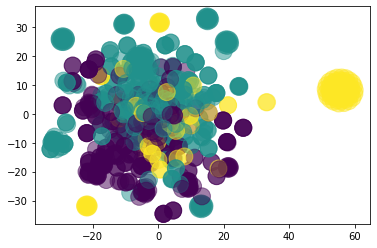

In [91]:
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
 
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
 
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
 

#for j in range(len(sentences)):    
#    plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#    print ("%s %s" % (assigned_clusters[j],  sentences[j]))
 
plt.show()